# Google Trends Analysis with BigQuery magic and Python SDK for BigQuery

## 1. BigQuery magic to analyze Google Trends

In [1]:
%%bigquery
SELECT
  country_code,
  country_name,
  COUNT(DISTINCT region_code) AS num_regions
FROM
  `bigquery-public-data.google_trends.international_top_terms`
WHERE
  refresh_date = DATE_SUB(CURRENT_DATE, INTERVAL 1 DAY)
GROUP BY
  country_code,
  country_name
ORDER BY
  num_regions DESC;

Downloading: 100%|██████████| 41/41 [00:01<00:00, 33.47rows/s]


,country_code,country_name,num_regions
0,TR,Turkey,81
1,TH,Thailand,77
2,VN,Vietnam,63
3,JP,Japan,47
4,RO,Romania,42
5,NG,Nigeria,37
6,IN,India,36
7,ID,Indonesia,34
8,CO,Colombia,33
9,MX,Mexico,32


### 2. Create a Pandas Dataframe called regionsByCountryPDF & visualize the same

In [11]:
%%bigquery regionsByCountryPDF
SELECT
  country_code,
  country_name,
  COUNT(DISTINCT region_code) AS num_regions
FROM
  `bigquery-public-data.google_trends.international_top_terms`
WHERE
  refresh_date = DATE_SUB(CURRENT_DATE, INTERVAL 1 DAY)
GROUP BY
  country_code, country_name
ORDER BY
  num_regions DESC;

Downloading: 100%|██████████| 41/41 [00:01<00:00, 28.36rows/s]


In [4]:
regionsByCountryPDF.head()

,country_code,country_name,num_regions
0,TR,Turkey,81
1,TH,Thailand,77
2,VN,Vietnam,63
3,JP,Japan,47
4,RO,Romania,42


<AxesSubplot:xlabel='country_name'>

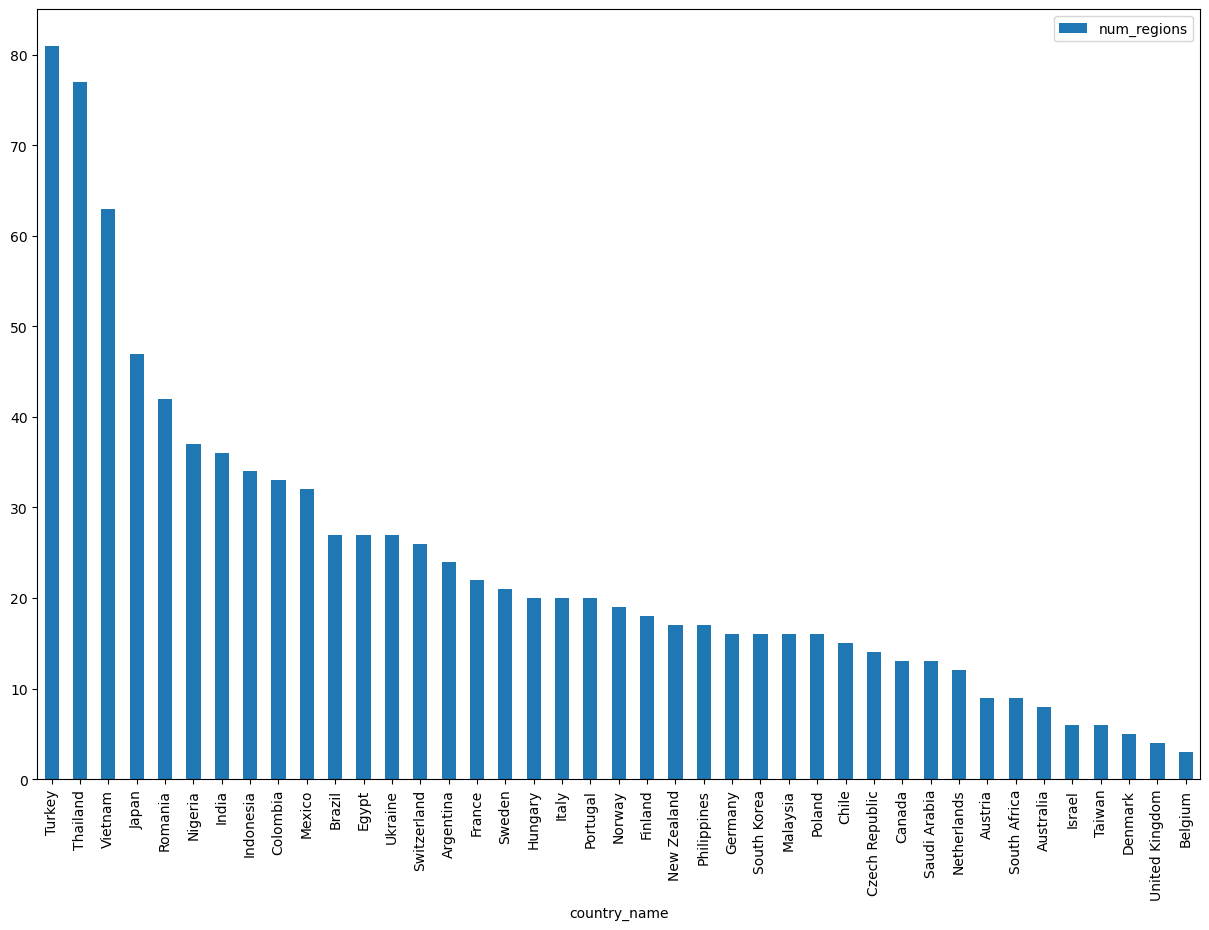

In [12]:
regionsByCountryPDF.plot(kind="bar", x="country_name", y="num_regions", figsize=(15, 10))

### 3. Use the Python SDK for BigQuery, analyze Google trends and visualize

In [13]:
from google.cloud import bigquery

client = bigquery.Client()

sql = """
WITH
  TopTermsByDate AS (
    SELECT DISTINCT refresh_date AS date, term
    FROM `bigquery-public-data.google_trends.top_terms`
  ),
  DistinctDates AS (
    SELECT DISTINCT date
    FROM TopTermsByDate
  )
SELECT
  DATE_DIFF(Dates2.date, Date1Terms.date, DAY)
    AS days_apart,
  COUNT(DISTINCT (Dates2.date || Date1Terms.date))
    AS num_date_pairs,
  COUNT(Date1Terms.term) AS num_date1_terms,
  SUM(IF(Date2Terms.term IS NOT NULL, 1, 0))
    AS overlap_terms,
  SAFE_DIVIDE(
    SUM(IF(Date2Terms.term IS NOT NULL, 1, 0)),
    COUNT(Date1Terms.term)
    ) AS pct_overlap_terms
FROM
  TopTermsByDate AS Date1Terms
CROSS JOIN
  DistinctDates AS Dates2
LEFT JOIN
  TopTermsByDate AS Date2Terms
  ON
    Dates2.date = Date2Terms.date
    AND Date1Terms.term = Date2Terms.term
WHERE
  Date1Terms.date <= Dates2.date
GROUP BY
  days_apart

ORDER BY
  days_apart;
"""
pctOverlapTermsByDaysApartPDF = client.query(sql).to_dataframe()
pctOverlapTermsByDaysApartPDF.head()

,days_apart,num_date_pairs,num_date1_terms,overlap_terms,pct_overlap_terms
0,0,32,800,800,1.000000
1,1,31,775,48,0.061935
2,2,30,750,16,0.021333
3,3,29,725,25,0.034483
4,4,28,700,15,0.021429


<AxesSubplot:xlabel='days_apart', ylabel='pct_overlap_terms'>

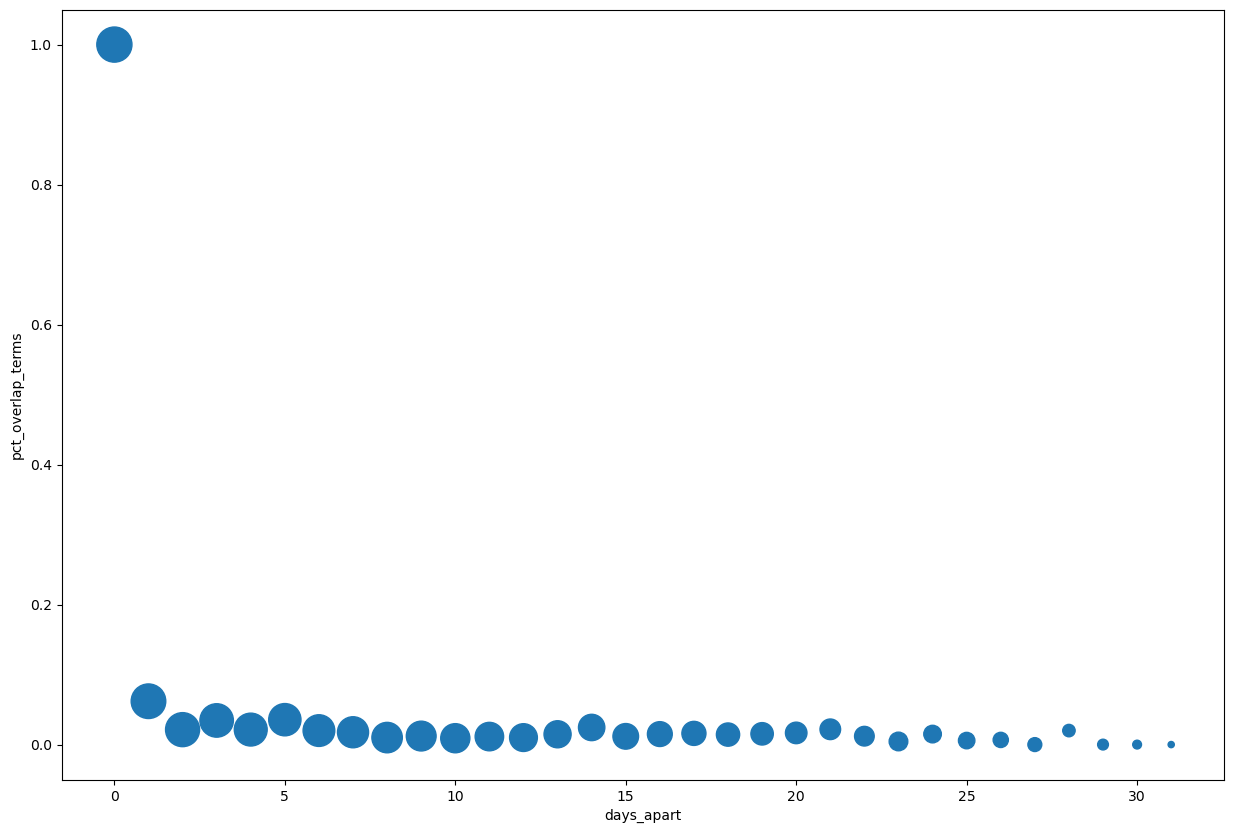

In [14]:
pctOverlapTermsByDaysApartPDF.plot(
  kind="scatter",
  x="days_apart",
  y="pct_overlap_terms",
  s=pctOverlapTermsByDaysApartPDF["num_date_pairs"] * 20,
  figsize=(15, 10)
  )